In [1]:
using Images
using PyPlot
using Statistics
using LinearAlgebra
using Printf
#import ImageMagick
#using FileIO

@inline isBigger(a, b) = (a > b)
@inline isSmaller(a, b) = (a < b)

include("Common.jl")

#---------------------------------------------------------
# Load ground truth disparity map
#
# Input:
#   filename:       the name of the disparity file
#
# Outputs:
#   disparity:      [h x w] ground truth disparity
#   mask:           [h x w] validity mask
#---------------------------------------------------------
function loadGTdisaprity(filename)
  disparity_gt = Float64.(PyPlot.imread(filename)) * 256
  mask = disparity_gt .> 0

  @assert size(mask) == size(disparity_gt)
  return disparity_gt::Array{Float64,2}, mask::BitArray{2}
end

#---------------------------------------------------------
# Calculate NC between two image patches
#
# Inputs:
#   patch1 : an image patch from the left image
#   patch2 : an image patch from the right image
#
# Output:
#   nc_cost : Normalized Correlation cost
#
#---------------------------------------------------------
function computeNC(patch1, patch2)
  height, width = size(patch1)

  v1 = reshape(patch1 .- mean(patch1), height*width, 1)
  v2 = reshape(patch2 .- mean(patch2), height*width, 1)

  nc_cost = sum(v1.*v2) / LinearAlgebra.norm(v1, 2) / LinearAlgebra.norm(v2, 2)

  return nc_cost::Float64
end

#---------------------------------------------------------
# Calculate SSD between two image patches
#
# Inputs:
#   patch1 : an image patch from the left image
#   patch2 : an image patch from the right image
#
# Output:
#   ssd_cost : SSD cost
#
#---------------------------------------------------------
function computeSSD(patch1, patch2)
  ssd_cost = sum((patch1-patch2).^2)
  return ssd_cost::Float64
end


#---------------------------------------------------------
# Calculate the error of estimated disparity
#
# Inputs:
#   disparity : estimated disparity result, [h x w]
#   disparity_gt : ground truth disparity, [h x w]
#   valid_mask : validity mask, [h x w]
#
# Output:
#   error_disparity : calculated disparity error
#   error_map:  error map, [h x w]
#
#---------------------------------------------------------
function calculateError(disparity, disparity_gt, valid_mask)
  error_map = abs.(disparity - disparity_gt).* valid_mask
  error_disparity = sum(error_map) / sum(valid_mask)

  @assert size(disparity) == size(error_map)
  return error_disparity::Float64, error_map::Array{Float64,2}
end


#---------------------------------------------------------
# Compute disparity
#
# Inputs:
#   gray_l : a gray version of the left image, [h x w]
#   gray_R : a gray version of the right image, [h x w]
#   max_disp: Maximum disparity for the search range
#   w_size: window size
#   cost_ftn: a cost function for caluclaing the cost between two patches
#             either computeSSD or computeNC
#
# Output:
#   disparity : disparity map, [h x w]
#
#---------------------------------------------------------
function computeDisparity(gray_l, gray_r, max_disp, w_size, cost_ftn::Function)

  # Padding image for the boundary handling
  height, width = size(gray_l)
  hf_size_h = Int64((w_size[1] - 1) / 2)
  hf_size_w = Int64((w_size[2] - 1) / 2)
  gray_l_pad = padarray(gray_l, Pad(:replicate, hf_size_h, hf_size_w))
  gray_r_pad = padarray(gray_r, Pad(:replicate, hf_size_h, hf_size_w))
  disparity = zeros(Int64, height, width)

  # Differentiating the cases between SSD and NC.
  init_cost = typemax(Float64)
  comp_ftn = isSmaller
  if cost_ftn == computeNC
    init_cost = 0
    comp_ftn = isBigger
  end

  # For each pixel
  for h1 = 1:height
    for w1 = 1:width
      min_cost = init_cost
      patch1 = gray_l_pad[h1-hf_size_h:h1+hf_size_h, w1-hf_size_w:w1+hf_size_w]

      # Calculate the cost for all possible cases
      for dd = 0:max_disp
        h2 = h1
        w2 = w1 - dd

        if w2 <= 0
          continue
        end

        patch2 = gray_r_pad[h2-hf_size_h:h2+hf_size_h, w2-hf_size_w:w2+hf_size_w]
        cost = cost_ftn(patch1, patch2)

        # Update the disparity
        if comp_ftn(cost, min_cost)
          min_cost = cost
          disparity[h1, w1] = dd
        end
      end
    end
  end

  @assert size(disparity) == size(gray_l)
  return disparity::Array{Int64,2}
end

#---------------------------------------------------------
#   An efficient implementation
#---------------------------------------------------------
function computeDisparityEff(gray_l, gray_r, max_disp, w_size)

  # Padding image for the boundary handling
  height, width = size(gray_l)
  hf_size_h = Int64((w_size[1] - 1) / 2)
  hf_size_w = Int64((w_size[2] - 1) / 2)
  gray_l_pad = padarray(gray_l, Pad(:replicate, hf_size_h, hf_size_w))
  gray_r_pad = padarray(gray_r, Pad(:replicate, hf_size_h, hf_size_w))

  # Variable Initialization
  disparity = zeros(Int64, height, width)
  aggregation_filter = ones(Int64, w_size[1], w_size[2])
  cost_volume = ones((size(gray_l)..., max_disp+1)) .* typemax(Float64)

  # Construct a cost volume that contains costs for all possible disparity
  for dd = 0:max_disp
    # Efficiently calculating the SSD cost: calculate SSD cost for an image & aggregating with filtering
    ssd_cost = (gray_l_pad[:, 1-hf_size_w+dd:end] - gray_r_pad[:, 1-hf_size_w:end-dd]).^2
    aggregated_ssd = imfilter(ssd_cost, centered(aggregation_filter), Inner())[:, 1+hf_size_w:end]
    # Save the cost image in the cost volume
    cost_volume[:,1+dd:end, dd+1] = aggregated_ssd
  end

  # Find disparity in the cost volume
  _, min_disp = findmin(cost_volume, dims=3)
  for ii=1:length(disparity)
    disparity[ii] = min_disp[ii][3] -1
  end

  @assert size(disparity) == size(gray_l)
  return disparity::Array{Int64,2}
end

#---------------------------------------------------------
# Problem 2: Stereo matching
#---------------------------------------------------------
function problem2()
  PyPlot.close("all")

  # Define parameters
  w_size = [5 5]
  max_disp = 100
  gt_file_name = "a4p2_gt.png"

  # Load both images
  gray_l, rgb_l = Common.loadimage("a4p2_left.png")
  gray_r, rgb_r = Common.loadimage("a4p2_right.png")

  # Load ground truth disparity
  disparity_gt, valid_mask = loadGTdisaprity(gt_file_name)

  # estimate disparity
  @time disparity_ssd = computeDisparity(gray_l, gray_r, max_disp, w_size, computeSSD)
  @time disparity_nc = computeDisparity(gray_l, gray_r, max_disp, w_size, computeNC)

  # Calculate Error
  error_disparity_ssd, error_map_ssd = calculateError(disparity_ssd, disparity_gt, valid_mask)
  @printf(" disparity_SSD error = %f \n", error_disparity_ssd)
  error_disparity_nc, error_map_nc = calculateError(disparity_nc, disparity_gt, valid_mask)
  @printf(" disparity_NC error = %f \n", error_disparity_nc)

  figure()
  subplot(2,1,1), imshow(disparity_ssd, interpolation="none"), axis("off"), title("disparity_ssd")
  subplot(2,1,2), imshow(error_map_ssd, interpolation="none"), axis("off"), title("error_map_ssd")
  gcf()

  figure()
  subplot(2,1,1), imshow(disparity_nc, interpolation="none"), axis("off"), title("disparity_nc")
  subplot(2,1,2), imshow(error_map_nc, interpolation="none"), axis("off"), title("error_map_nc")
  gcf()

  figure()
  imshow(disparity_gt)
  axis("off")
  title("disparity_gt")
  gcf()

  @time disparity_ssd_eff = computeDisparityEff(gray_l, gray_r, max_disp, w_size)
  error_disparity_ssd_eff, error_map_ssd_eff = calculateError(disparity_ssd_eff, disparity_gt, valid_mask)
  @printf(" disparity_SSD_eff error = %f \n", error_disparity_ssd_eff)

  figure()
  subplot(2,1,1), imshow(disparity_ssd_eff, interpolation="none"), axis("off"), title("disparity_ssd_eff")
  subplot(2,1,2), imshow(error_map_ssd_eff, interpolation="none"), axis("off"), title("error_map_ssd_eff")
  gcf()

  return nothing::Nothing
end




problem2 (generic function with 1 method)

 31.278772 seconds (181.05 M allocations: 43.885 GiB, 6.65% gc time)
 32.435231 seconds (361.64 M allocations: 64.740 GiB, 11.87% gc time)
 disparity_SSD error = 11.988575 
 disparity_NC error = 17.716913 


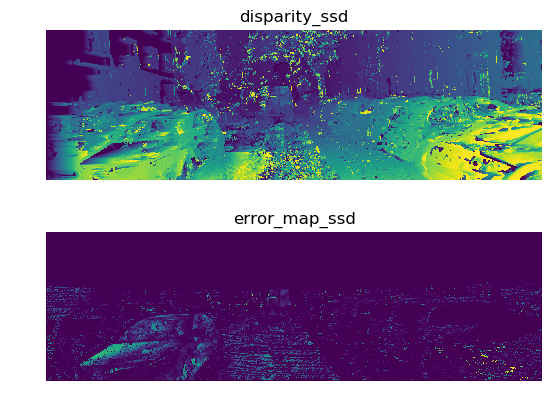

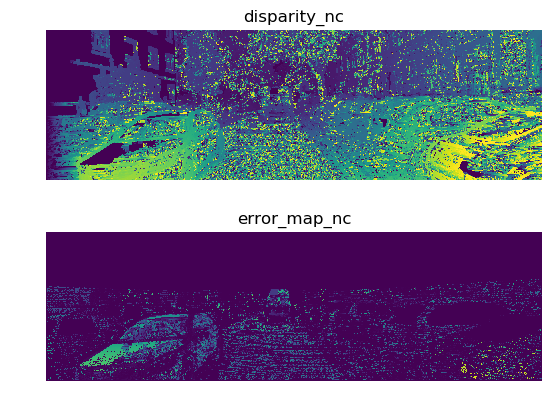

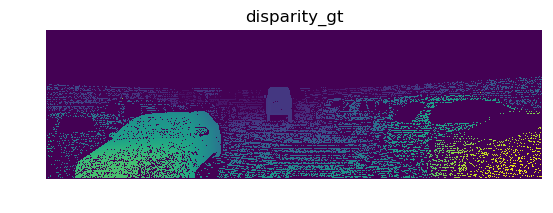

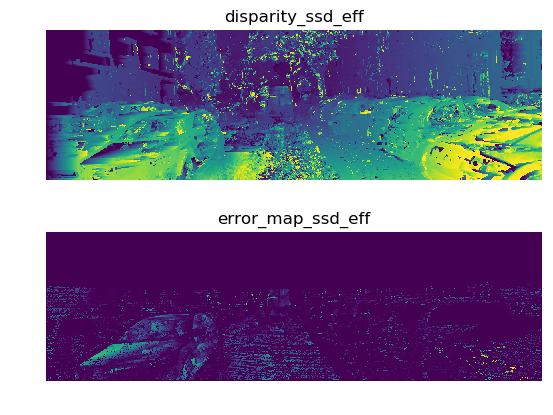

  4.044993 seconds (108.87 k allocations: 3.118 GiB, 24.44% gc time)
 disparity_SSD_eff error = 11.988566 


In [2]:
problem2()